# SOC stock change by land cover type
### Python libraries

In [1]:
import sys
sys.path.append("../../processing/")

import os 

import numpy as np
import xarray as xr
import pandas as pd
from dotenv import load_dotenv
from dask.distributed import Client

from utils.data import VectorData, LandCoverData, LandCoverRasterData
from utils.calculations import LandCoverStatistics
from utils.util import remove_small_polygons, split_geometry_with_antimeridian

# Load .env VARIABLEs
load_dotenv()

True

In [2]:
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 14.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34205,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 14.98 GiB
Comm: tcp://127.0.0.1:45803,Total threads: 4
Dashboard: http://127.0.0.1:43757/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:41219,


### Utils

In [3]:
import matplotlib.pyplot as plt

def get_plot(data, land_cover_colors, land_cover_labels, categories=None):
    categories = list(data.keys())

    lists_labels = [list(value.keys()) for value in data.values()]
    labels = list(set([item for sublist in lists_labels for item in sublist]))


    # Calculate the positions of the bars on the y-axis
    bar_positions = range(len(categories))

    # Create the plot
    fig, ax = plt.subplots()

    for n, label in enumerate(labels):
        values_positive = []
        values_negative = []
        for category in categories[::-1]:
            data_dict = data[category]
            if label in data_dict.keys():
                value = data_dict[label]
                if value > 0:
                    values_positive.append(value)
                    values_negative.append(0)
                else:
                    values_negative.append(value)
                    values_positive.append(0)
            else:
                values_negative.append(0)
                values_positive.append(0)

        if n == 0:
            ax.barh(bar_positions, values_positive, label=land_cover_labels[label], color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, color=land_cover_colors[label])

            values_positive_pre = values_positive
            values_negative_pre = values_negative
        elif n == 1:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]
        else:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]

    # Add a dashed line at x = 0
    ax.axvline(0, color='black', linestyle='dashed')

    ## Set the y-axis ticks and labels
    ax.set_yticks(bar_positions)
    if not categories:
        categories = [land_cover_labels[str(category)] for category in categories]
        
    ax.set_yticklabels(categories[::-1])
    ax.yaxis.set_ticks_position('none')
    ax.set_ylabel('Land Cover 2018')

    # Set the x-axis label
    ax.set_xlabel('SOC stock change (t C/ha)')

    # Remove the frame
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the title of the legend
    legend.set_title('Land Cover 2000')

    # Expand the plot's size to accommodate the legend
    plt.subplots_adjust(right=0.8)

    return plt

## Compute Land Cover Statistics

### Recent
#### Compute statistics

In [21]:
RASTER_PATH = '../../data/processed/raster_data/'
vector_path = '../../data/processed/vector_data/'
vector_prefixes = ['political_boundaries']#['political_boundaries', 'biomes']
read_data_from = 'local_dir'
variable = 'stocks'
group_type = 'recent'
READ_DATA_FROM = 'local_dir'
SCENARIOS = None

# Read vector data
print("Reading vector data!")
vector = VectorData(vector_path, vector_prefixes)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')
#vector_data_0['political_boundaries_0'] = vector_data_0['political_boundaries_0'][vector_data_0['political_boundaries_0']['gid_0'].isin(['ESP'])]
#vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'][vector_data_1['political_boundaries_1']['gid_0'].isin(['ESP'])]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'].iloc[960:961]

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
raster = LandCoverRasterData(group_type=group_type, data_from=READ_DATA_FROM, path=RASTER_PATH)
raster_data = raster.read_data() 

# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
data = {}
lc_statistics = LandCoverStatistics(group_type, raster_data, lc_metadata, SCENARIOS)
# compute level 1 geometries' values
print("Level 1 geometries.")
data.update(lc_statistics.compute_level_1_data(vector_data_1))
# compute level 0 geometries' values
print("Level 0 geometries.")
data.update(lc_statistics.compute_level_0_data(vector_data_0))

### Save data
#print("Saving the data!")
#for geom_type in vector_prefixes:
#    df = pd.concat([data[key] for key in data if geom_type in key])
#    df = df.sort_values(['id_0', 'id'])
#    df['variable'] = variable
#    df['group_type'] = group_type
##   df.to_csv(f"../data/processed/precalculations/{geom_type}_land_cover_{group_type}.csv", index=False)

Reading vector data!


  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [57]:
RASTER_PATH = '../../data/processed/raster_data/'
vector_path = '../../data/processed/vector_data/'
vector_prefixes = ['political_boundaries']#['hydrological_basins']#['political_boundaries', 'biomes']
variable = 'stocks'
group_type = 'recent'
READ_DATA_FROM = 'local_dir'
SCENARIOS = None

# Read vector data
print("Reading vector data!")
vector = VectorData(vector_path, vector_prefixes)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')
#vector_data_0['biomes_0'] = vector_data_0['biomes_0'][vector_data_0['biomes_0']['id_0'].isin([10])]
#vector_data_1['biomes_1'] = vector_data_1['biomes_1'][vector_data_1['biomes_1']['id_0'].isin([10])]
#vector_data_0['hydrological_basins_0'] = vector_data_0['hydrological_basins_0'].iloc[121:122]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'].iloc[960:961]

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
raster = LandCoverRasterData(group_type=group_type, data_from=READ_DATA_FROM, path=RASTER_PATH)
raster_data = raster.read_data() 

# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
data = {}
lc_statistics = LandCoverStatistics(group_type, raster_data, lc_metadata, SCENARIOS)
# compute level 1 geometries' values
print("Level 1 geometries.")
#data.update(lc_statistics.compute_level_1_data(vector_data_1))
## compute level 0 geometries' values
print("Level 0 geometries.")
#data.update(lc_statistics.compute_level_0_data(vector_data_0))

Reading vector data!


100%|██████████| 1/1 [00:11<00:00, 11.53s/it]

Reading raster data!
Compute Land Cover Statistics!
Level 1 geometries.
Level 0 geometries.


In [25]:
for geom_name, gdf in vector_data_1.items():
    print(f"Computing land cover statistics for vector data -> {geom_name}")
    indexes = gdf['index'].tolist()
    index = indexes[0]
    
    gdf_index  = gdf[gdf['index'] == index].copy()
    
    # Get bounds
    xmin_180, ymin, xmax_180, ymax = gdf_index.to_crs("+proj=latlong +datum=WGS84 +lon_0=180")['geometry'].iloc[0].bounds
    geom = gdf_index['geometry'].iloc[0]
    xmin, ymin, xmax, ymax = geom.bounds

Computing land cover statistics for vector data -> political_boundaries_1


In [58]:
for geom_name, gdf in vector_data_1.items():
    print(f"Computing land cover statistics for vector data -> {geom_name}")
    indexes = gdf['index'].tolist()
    index = indexes[0]
    
    gdf_index  = gdf[gdf['index'] == index].copy()

    # Get bounds
    xmin_180, ymin, xmax_180, ymax = gdf_index.to_crs("+proj=latlong +datum=WGS84 +lon_0=180")['geometry'].iloc[0].bounds
    geom = gdf_index['geometry'].iloc[0]
    xmin, ymin, xmax, ymax = geom.bounds
    
# Take care of the antimeridian
if not round(xmin_180) <= -179 and not round(xmax_180) >= 179:
    if round(xmin) <= -175 and round(xmax) >= 175:
        print('Split the geometry with the antimeridian')
        # Split the geometry with the antimeridian.
        gdf_split = split_geometry_with_antimeridian(gdf_index)
        
        ds_list = []
        for side in ['left', 'right']:
            gdf_side = gdf_split[gdf_split['side'] == side].drop(columns="side")
            geom = gdf_side['geometry'].iloc[0]
            xmin, ymin, xmax, ymax = geom.bounds
            ds_side = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)) 
            # Rasterize vector data
            ds_list.append(lc_statistics._rasterize_vector_data(ds_side, 
                                                        gdf_side.drop(columns="index").reset_index(),
                                                        'index', 'x', 'y'))

        # Combine the two datasets using combine_by_coords
        ds_index = xr.combine_by_coords(ds_list)
    else:
        ds_index = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).copy()
        # Rasterize vector data
        ds_index = lc_statistics._rasterize_vector_data(ds_index, 
                                                        gdf_index.drop(columns="index").reset_index(), 
                                                        'index', 'x', 'y')
else:
        ds_index = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).copy()
        # Rasterize vector data
        ds_index = lc_statistics._rasterize_vector_data(ds_index, 
                                                        gdf_index.drop(columns="index").reset_index(), 
                                                        'index', 'x', 'y')

ds_index = ds_index.where(ds_index['mask'].isin(index))

Computing land cover statistics for vector data -> political_boundaries_1
Split the geometry with the antimeridian


In [60]:
ds_side_recent = ds_side

#### Display statistics

In [11]:
lc_metadata = LandCoverData()
df = data['political_boundaries_0']

land_cover_groups = df['land_cover_groups'].iloc[0]
land_cover_group_2018 = df['land_cover_group_2018'].iloc[0]
land_cover = df['land_cover'].iloc[0]

lc_list = list(land_cover_groups.keys())

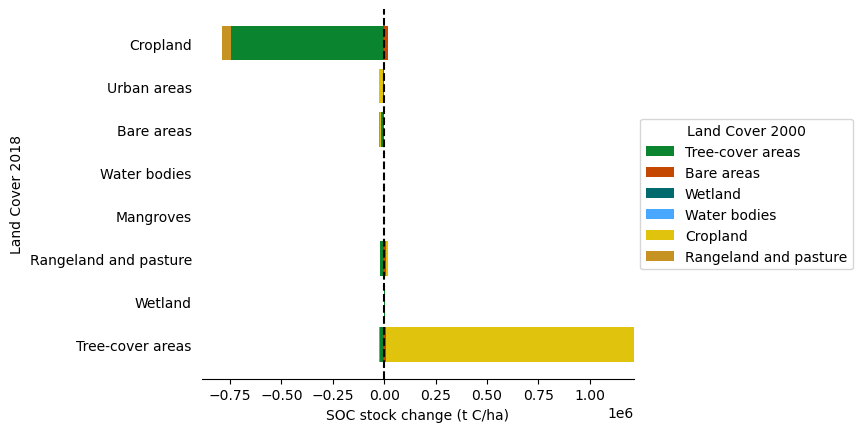

In [12]:
plt = get_plot(land_cover_groups, lc_metadata.parent_colors(), lc_metadata.parent_labels())

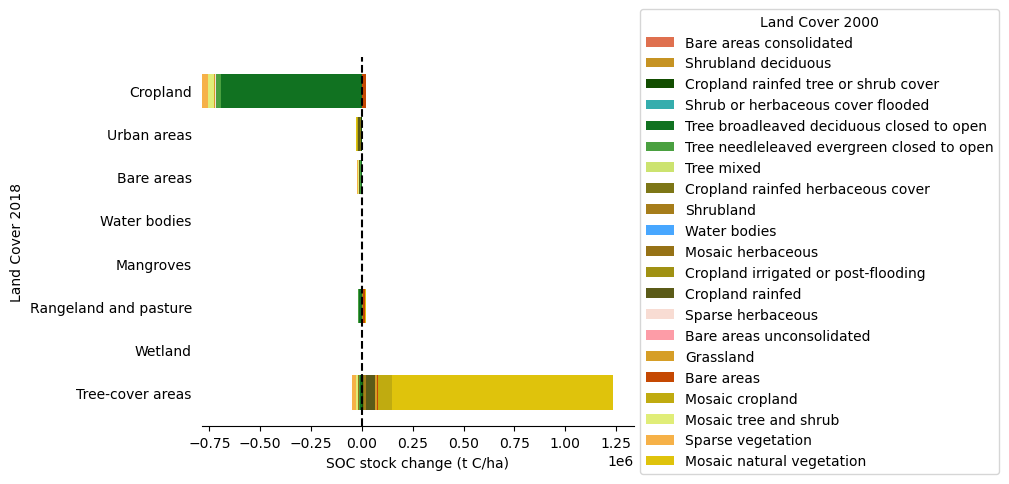

In [13]:
labels = lc_metadata.parent_labels()
labels.update(lc_metadata.child_labels())
colors = lc_metadata.parent_colors()
colors.update(lc_metadata.child_colors())
plt = get_plot(land_cover_group_2018, colors, labels)

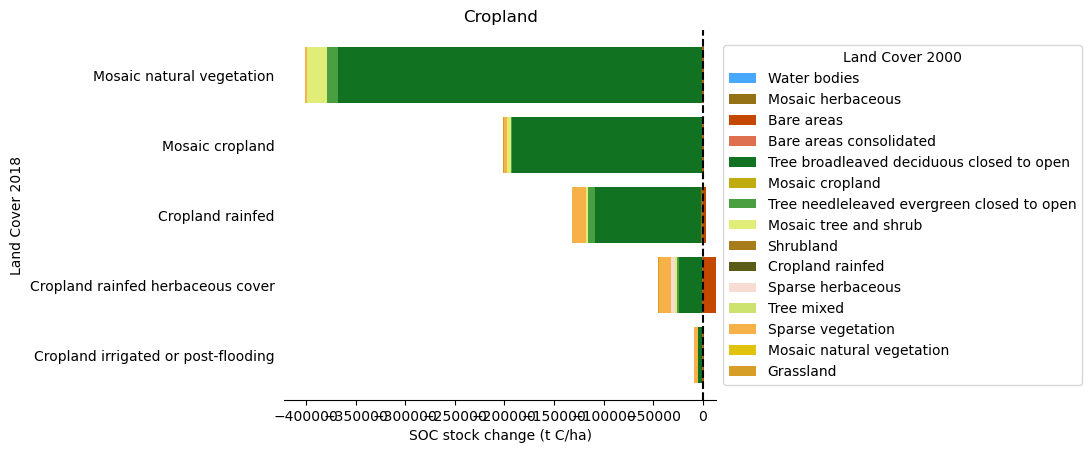

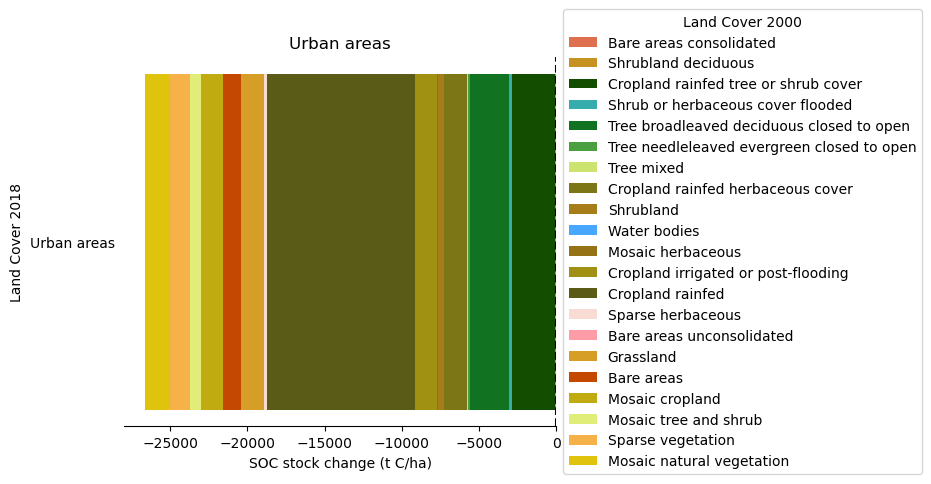

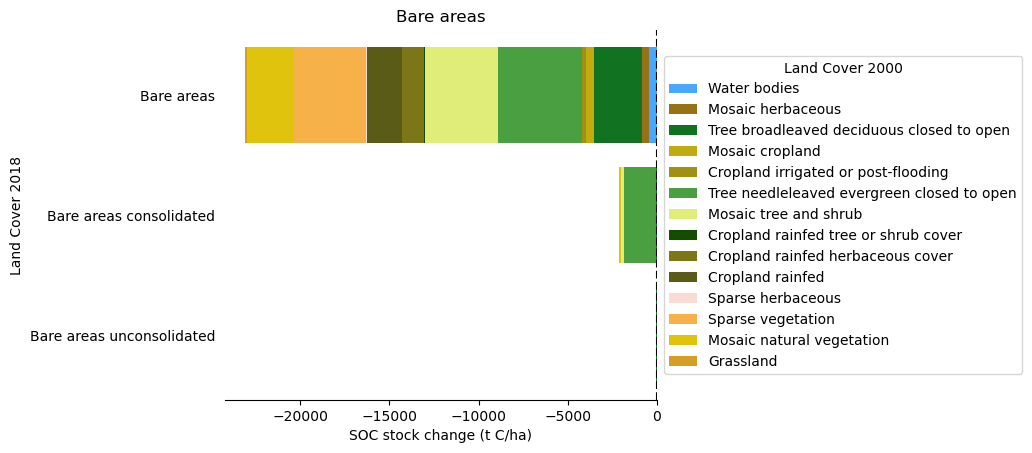

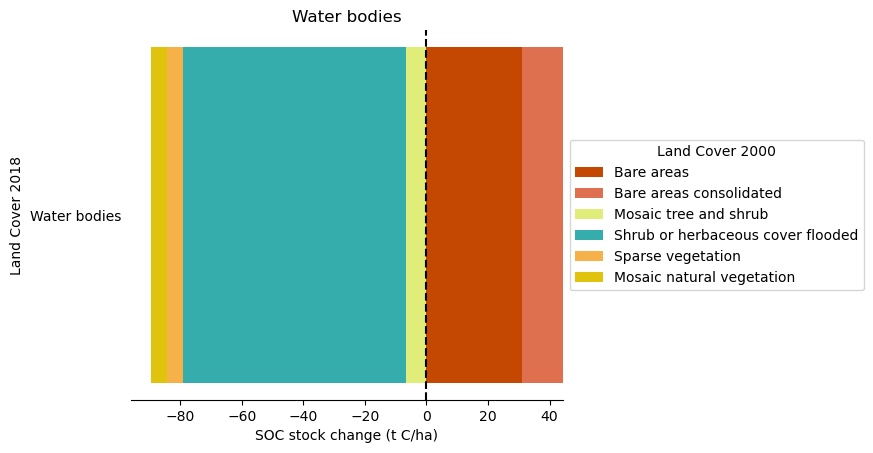

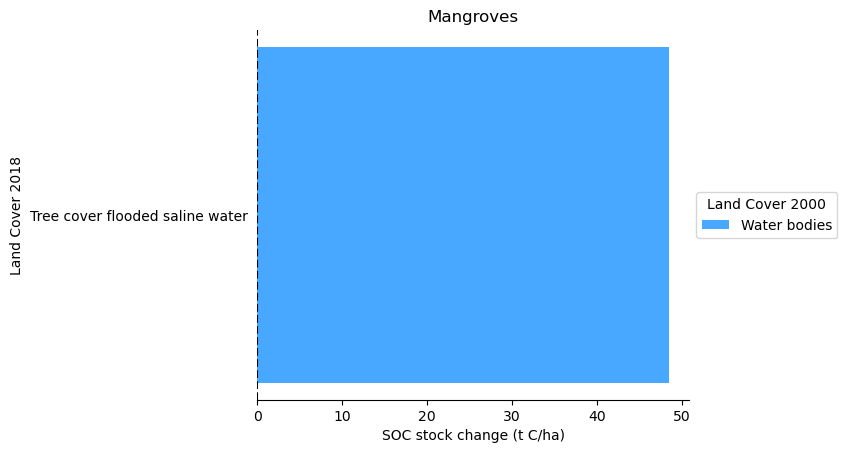

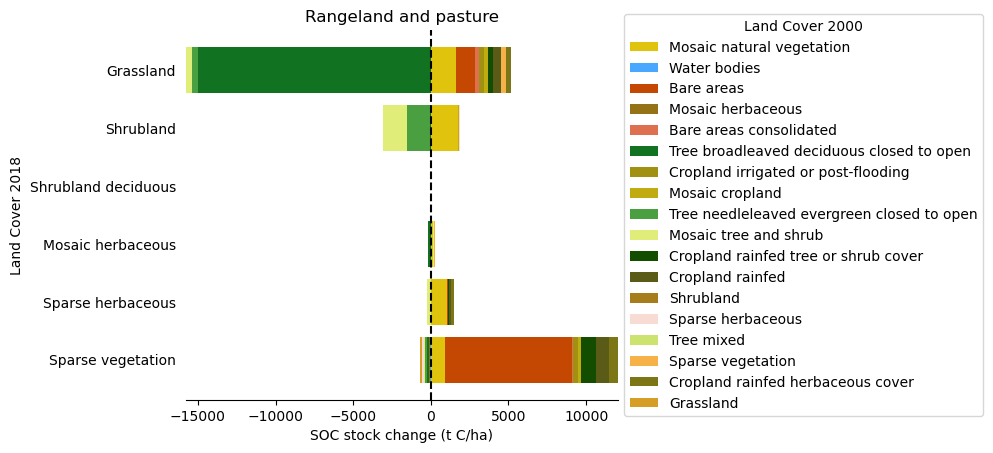

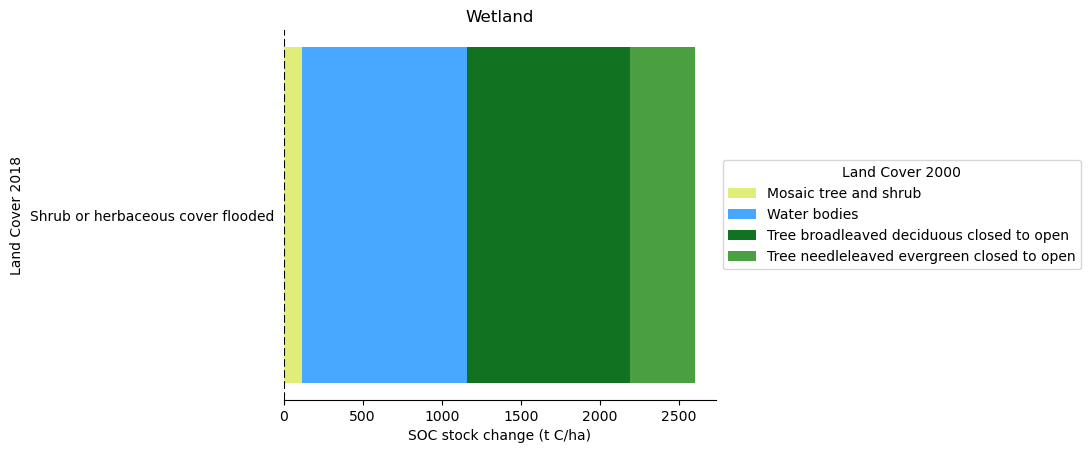

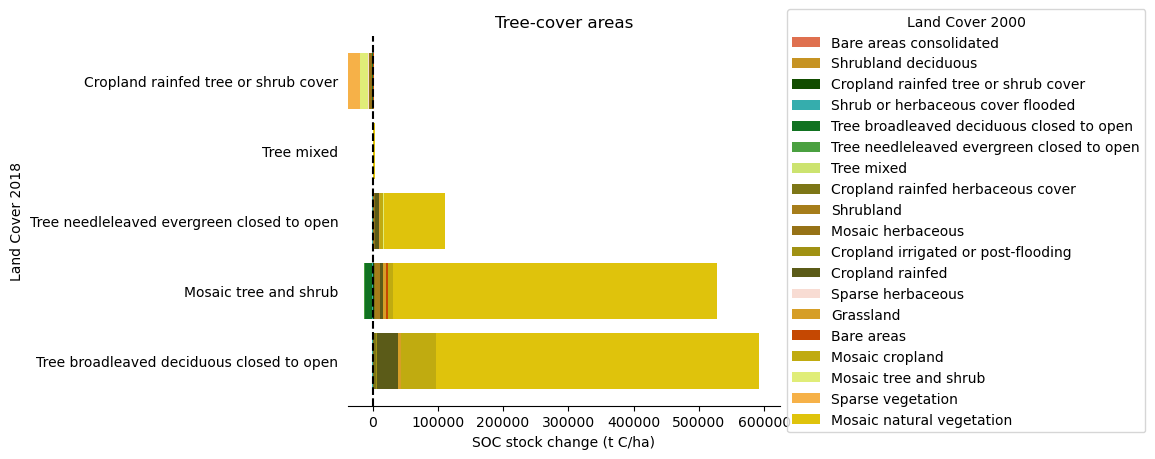

In [14]:
for num in lc_list:
    plt = get_plot(df['land_cover'].iloc[0][num], lc_metadata.child_colors(), lc_metadata.child_labels())
    plt.title(labels[num])

### Future
#### Compute statistics

In [6]:
RASTER_PATH = '../../data/processed/raster_data/'
VECTOR_DATA = '../../data/processed/vector_data/'
VECTOR_PREFIXED = ['political_boundaries']#['political_boundaries', 'biomes']
SCENARIOS = ['crop_I', 'crop_MG', 'crop_MGI', 'grass_part', 'grass_full', 'degradation_ForestToCrop', 'degradation_ForestToGrass', 'degradation_NoDeforestation', 'rewilding']  
READ_DATA_FROM = 's3'#'local_dir'
GROUP_TYPE = 'future'
VARIABLE = 'stocks'

# Read vector data
print("Reading vector data!")
vector = VectorData(VECTOR_DATA, VECTOR_PREFIXED)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')
#vector_data_0['political_boundaries_0'] = vector_data_0['political_boundaries_0'][vector_data_0['political_boundaries_0']['gid_0'].isin(['ESP', 'FRA'])]
#vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'][vector_data_1['political_boundaries_1']['gid_0'].isin(['ESP', 'FRA'])]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'].iloc[960:961]

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
raster = LandCoverRasterData(group_type=GROUP_TYPE, data_from=READ_DATA_FROM, path=RASTER_PATH, scenarios=SCENARIOS)
raster_data = raster.read_data() 

# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
data = {}
lc_statistics = LandCoverStatistics(GROUP_TYPE, raster_data, lc_metadata, SCENARIOS)
# compute level 1 geometries' values
print("Level 1 geometries.")
#data.update(lc_statistics.compute_level_1_data(vector_data_1))
# compute level 0 geometries' values
print("Level 0 geometries.")
#data.update(lc_statistics.compute_level_0_data(vector_data_0))

### Save data
#print("Saving the data!")
#for geom_type in vector_prefixes:
#    df = pd.concat([data[key] for key in data if geom_type in key])
#    df = df.sort_values(['id_0', 'id'])
#    df['variable'] = VARIABLE
#    df['group_type'] = GROUP_TYPE
#    df.to_csv(f"../../data/processed/precalculations/{geom_type}_land_cover_{GROUP_TYPE}.csv", index=False)

Reading vector data!


100%|██████████| 1/1 [00:11<00:00, 11.01s/it]


Reading raster data!
Compute Land Cover Statistics!
Level 1 geometries.
Level 0 geometries.


In [4]:
for geom_name, gdf in vector_data_1.items():
    print(f"Computing land cover statistics for vector data -> {geom_name}")
    indexes = gdf['index'].tolist()
    index = indexes[0]
    
    gdf_index  = gdf[gdf['index'] == index].copy()
    
    # Get bounds
    xmin_180, ymin, xmax_180, ymax = gdf_index.to_crs("+proj=latlong +datum=WGS84 +lon_0=180")['geometry'].iloc[0].bounds
    geom = gdf_index['geometry'].iloc[0]
    xmin, ymin, xmax, ymax = geom.bounds

Computing land cover statistics for vector data -> political_boundaries_1


In [7]:
for geom_name, gdf in vector_data_1.items():
    print(f"Computing land cover statistics for vector data -> {geom_name}")
    indexes = gdf['index'].tolist()
    index = indexes[0]
    
    gdf_index  = gdf[gdf['index'] == index].copy()

    # Get bounds
    xmin_180, ymin, xmax_180, ymax = gdf_index.to_crs("+proj=latlong +datum=WGS84 +lon_0=180")['geometry'].iloc[0].bounds
    geom = gdf_index['geometry'].iloc[0]
    xmin, ymin, xmax, ymax = geom.bounds
    
# Take care of the antimeridian
if not round(xmin_180) <= -179 and not round(xmax_180) >= 179:
    if round(xmin) <= -175 and round(xmax) >= 175:
        print('Split the geometry with the antimeridian')
        # Split the geometry with the antimeridian.
        gdf_split = split_geometry_with_antimeridian(gdf_index)
        
        ds_list = []
        for side in ['left', 'right']:
            gdf_side = gdf_split[gdf_split['side'] == side].drop(columns="side")
            geom = gdf_side['geometry'].iloc[0]
            xmin, ymin, xmax, ymax = geom.bounds
            ds_side = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)) 
            # Rasterize vector data
            ds_list.append(lc_statistics._rasterize_vector_data(ds_side, 
                                                        gdf_side.drop(columns="index").reset_index(),
                                                        'index', 'x', 'y'))

        # Combine the two datasets using combine_by_coords
        ds_index = xr.combine_by_coords(ds_list)
    else:
        ds_index = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).copy()
        # Rasterize vector data
        ds_index = lc_statistics._rasterize_vector_data(ds_index, 
                                                        gdf_index.drop(columns="index").reset_index(), 
                                                        'index', 'x', 'y')
else:
        ds_index = lc_statistics.raster_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).copy()
        # Rasterize vector data
        ds_index = lc_statistics._rasterize_vector_data(ds_index, 
                                                        gdf_index.drop(columns="index").reset_index(), 
                                                        'index', 'x', 'y')

ds_index = ds_index.where(ds_index['mask'].isin(index))

Computing land cover statistics for vector data -> political_boundaries_1
Split the geometry with the antimeridian


#### Display statistics

In [23]:
lc_metadata = LandCoverData()
df = data['political_boundaries_0']

land_cover_groups = df['land_cover_groups'].iloc[0]
land_cover = df['land_cover'].iloc[0]

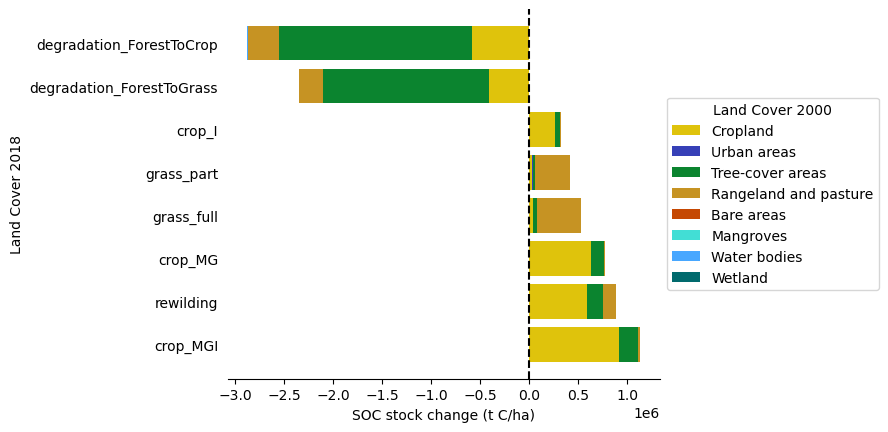

In [25]:
keys = list(land_cover_groups.keys())
plt = get_plot(land_cover_groups, lc_metadata.parent_colors(), lc_metadata.parent_labels(), categories=keys)

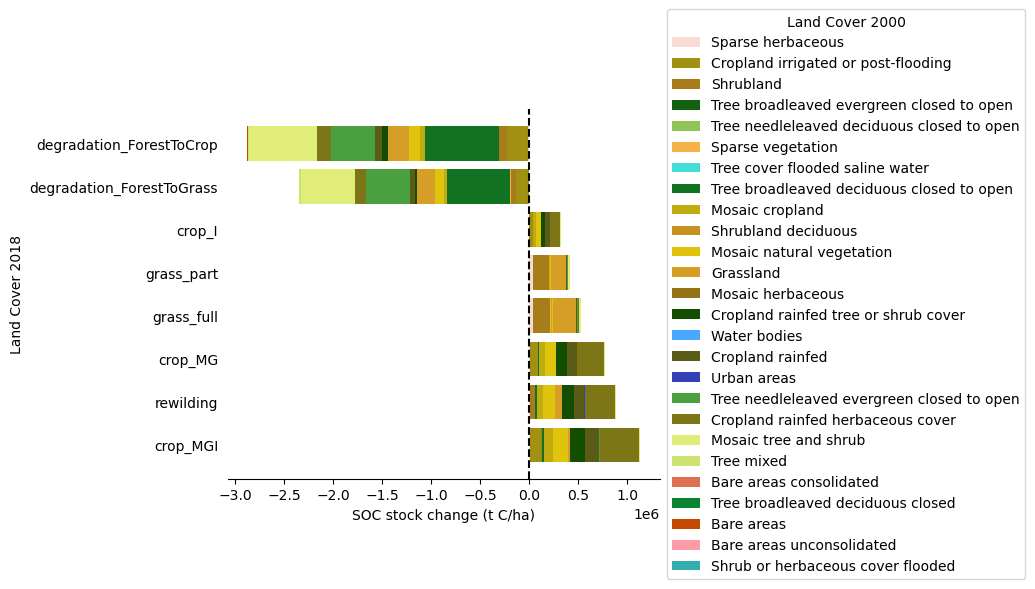

In [26]:
keys = list(land_cover_groups.keys())
plt = get_plot(land_cover, lc_metadata.child_colors(), lc_metadata.child_labels(), categories=keys)